In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys
#sys.path.insert(0, '/home/aew492/lss-dipoles')
#sys.path.insert(0, '/home/investigator/code/lss-dipoles')
sys.path.insert(0, '..')
import tools
from qso_sample import QSOSample
import dipole
import ellisbaldwin
import multipoles
from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife

In [115]:
import matplotlib
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 16

matplotlib.rc('text', usetex=True)

In [4]:
basedir = '../../quasar_data_abby/catalogs'

In [110]:
color_quaia = 'mediumvioletred'
color_catwise = 'teal'
lw = 2
lw_grid = 0.5

### functions

In [6]:
def C_1(dipole_amplitude):  # from the new Abghari et al. (including Douglas Scott), eq. 3.3
    # return dipole_amplitude**2 / 3
    return 4 * np.pi / 9 * dipole_amplitude**2

def D(C_1):
    return np.sqrt(C_1) * 9 / (4 * np.pi)

In [7]:
# define function for jackknife: output needs to be just the Cells, to compute the uncertainty
def Cells_for_jk(overdensity_map, Wmask, max_ell, selfunc=None):
    ells, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map, Wmask, max_ell, selfunc=selfunc)
    return Cells

### load samples and construct overdensity maps

In [8]:
# some key variables !!

# ABBY
#catdir = '/scratch/aew492/quasars/catalogs'
#selfuncdir_quaia = os.path.join(catdir, 'quaia/selfuncs')
#selfuncdir_catwise = os.path.join(catdir, 'catwise_agns/selfuncs')

# KSF
catdir =  '../../quasar_data_abby/catalogs'
selfuncdir_quaia = '../../gaia-quasars-lss/data/maps/'
selfuncdir_catwise = '../../gaia-quasars-lss/data/maps/'

mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')
Wmask = 0.1  # fiducial regularization
max_ell = 8  # max ell to fit

#### CatWISE

In [9]:
# instantiate dipole object:
d = QSOSample(initial_catfn=os.path.join(catdir, 'catwise_agns/catwise_agns_master.fits'),
              mask_fn=mask_fn,
              mag='W1', maglim=16.4,
              basedir=basedir,
              blim=30)
d.cut_galactic_plane()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_catwise = ellisbaldwin.compute_expected_dipole_wise(d.table, maglimit=d.maglim,
                                                            min_w1=16., max_w1=16.5)  # reasonable min and max around the magnitude limit
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, ../../quasar_data_abby/catalogs/catwise_agns/catwise_agns_master.fits
8532854 sources in initial catalog.
cut |b| <= 30 -> 4479160 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.748
	effective alpha = 1.270
	expected dipole amplitude = 0.0074
cut W1 > 16.4 -> 1400045 sources left.


In [10]:
# at the healpix level:

# load selection function
# selfunc_catwise = d.get_selfunc(os.path.join(catdir, 'catwise_agns/selfuncs',
#                                             f'selection_function_NSIDE{d.NSIDE}_catwise_pluszodis.fits'))
selfunc_catwise = d.get_selfunc(os.path.join(selfuncdir_catwise,
                                            f'selection_function_NSIDE{d.NSIDE}_catwise_pluszodis.fits'))

# construct overdensity map with no selection function
overdensity_map_catwise = d.construct_overdensity_map(selfunc=None)

# and with the selection function
overdensity_map_sf_catwise = d.construct_overdensity_map(selfunc=selfunc_catwise)

constructing overdensity map
selection function not provided; assuming completeness = 1 in every pixel
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5
constructing overdensity map


In [11]:
# for CatWISE, we also want to correct for a density trend in ecliptic latitude, to match Secrest:
# get the ecliptic latitudes of each healpixel
lon, lat = hp.pix2ang(d.NSIDE, np.arange(hp.nside2npix(d.NSIDE)), lonlat=True)
elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat

# construct the masked datamap
masked_datamap = d.construct_masked_datamap(selfunc=None, return_map=True)

# fit a line: density vs elat
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap)
p = np.polyfit(np.abs(elat)[idx], masked_datamap[idx], deg=1)
# correct the densities and fit to the corrected densities
map_elatcorr = masked_datamap - np.polyval(p, np.abs(elat.value)) + p[1]
p_corr = np.polyfit(np.abs(elat)[idx], map_elatcorr[idx], deg=1) # in case we want to check the corrected trend
# then the overdensity map is
overdensity_map_elat_catwise = map_elatcorr / np.nanmean(map_elatcorr) - 1

selection function not provided; assuming completeness = 1 in every pixel


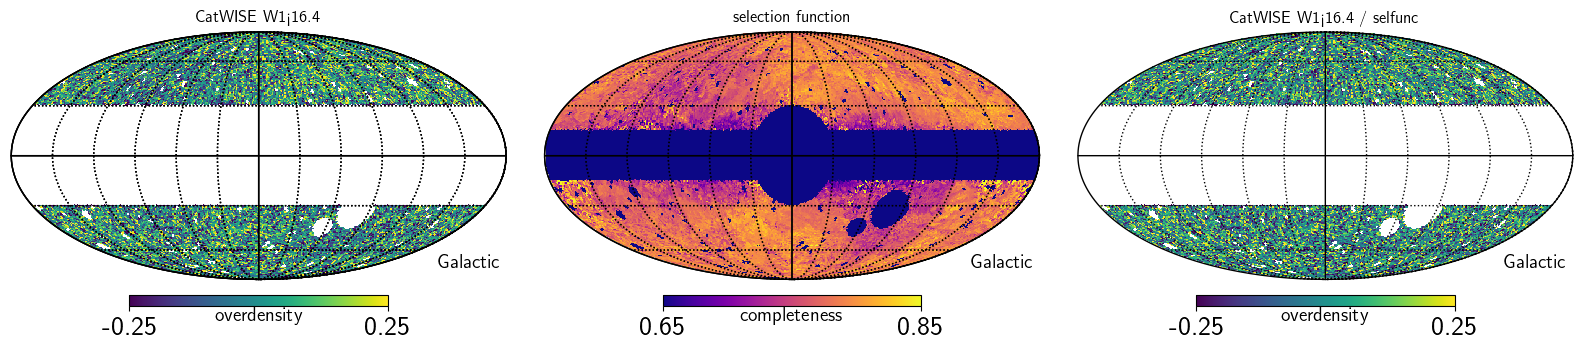

In [12]:
# plot to compare
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_catwise, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'CatWISE W1<{d.maglim}')
hp.graticule()
hp.mollview(selfunc_catwise, coord=['C','G'], min=0.65, max=0.85, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()
hp.mollview(overdensity_map_sf_catwise, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,3),
            unit='overdensity', title=f'CatWISE W1<{d.maglim} / selfunc')
hp.graticule()

#### Quaia

In [69]:
# instantiate dipole object:
d = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
              mask_fn=mask_fn,
              mag='g', maglim=20.,
              blim=30)
d.cut_galactic_plane()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_quaia = ellisbaldwin.compute_expected_dipole_gaia(d.table, maglimit=d.maglim,
                                                            min_g=19.5, max_g=20.5)  # reasonable min and max around the magnitude limit
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, ../../quasar_data_abby/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 30 -> 917566 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.309
	effective alpha = 0.713
	expected dipole amplitude = 0.0052
cut G > 20.0 -> 530364 sources left.


In [70]:
# at the healpix level:

# load selection function
selfunc_quaia_blim15 = d.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}_blim15.fits')) # note the blim15 !
# overdensity map, corrected by selection function
overdensity_map_sf_quaia_blim15 = d.construct_overdensity_map(selfunc=selfunc_quaia_blim15)

constructing overdensity map
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


In [71]:
# at the healpix level:

# load selection function
selfunc_quaia_full = d.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}.fits'))
# overdensity map, corrected by selection function
overdensity_map_sf_quaia_full = d.construct_overdensity_map(selfunc=selfunc_quaia_full)

constructing overdensity map


In [72]:
# at the healpix level:

# load selection function
selfunc_quaia_fullzodis = d.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}_pluszodis.fits'))
# overdensity map, corrected by selection function
overdensity_map_sf_quaia_fullzodis = d.construct_overdensity_map(selfunc=selfunc_quaia_fullzodis)

constructing overdensity map


In [73]:
# CHOOSE FIDUCIAL QUAIA SELFUNC
selfunc_quaia = selfunc_quaia_full
overdensity_map_sf_quaia = overdensity_map_sf_quaia_full

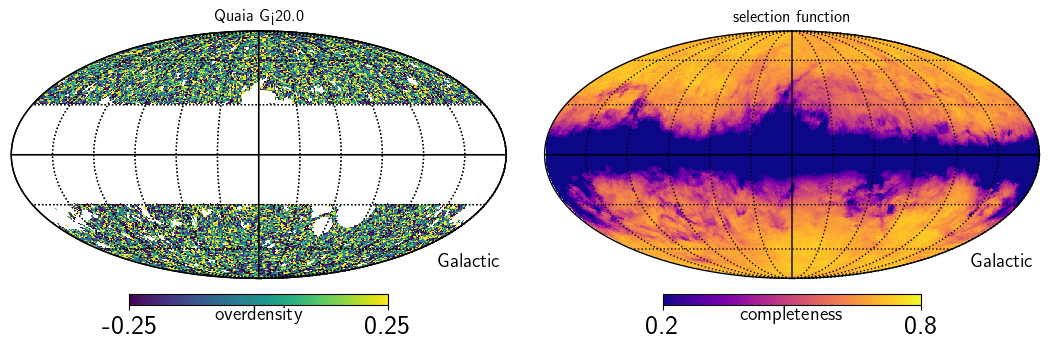

In [74]:
# plot
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_sf_quaia, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'Quaia G<{d.maglim}')
hp.graticule()
hp.mollview(selfunc_quaia, coord=['C','G'], min=0.2, max=0.8, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()

### dipoles, Cells, etc !

#### jackknife subsamples

In [75]:
nsamples = 12
lonavg, subsamples_catwise = get_longitude_subsamples_from_hpmap(overdensity_map_elat_catwise, nsamples, input_frame='icrs')
lonavg, subsamples_sf_catwise = get_longitude_subsamples_from_hpmap(overdensity_map_sf_catwise, nsamples, input_frame='icrs')
lonavg, subsamples_quaia = get_longitude_subsamples_from_hpmap(overdensity_map_sf_quaia, nsamples, input_frame='icrs')
jk_subsamples = [subsamples_catwise, subsamples_sf_catwise, subsamples_quaia]

#### measure dipoles in each overdensity map

In [76]:
# CatWISE
# no selection function, ecliptic latitude density correction
comps_catwise = dipole.measure_dipole_in_overdensity_map(overdensity_map_elat_catwise, Wmask=Wmask, selfunc=None)
print(dipole.get_dipole(comps_catwise))  # turns the 3 dipole components into an amplitude and direction
# selection function
comps_sf_catwise = dipole.measure_dipole_in_overdensity_map(overdensity_map_sf_catwise, Wmask=Wmask, selfunc=selfunc_catwise)
print(dipole.get_dipole(comps_sf_catwise))

# Quaia
comps_quaia = dipole.measure_dipole_in_overdensity_map(overdensity_map_sf_quaia, Wmask=Wmask, selfunc=selfunc_quaia)
print(dipole.get_dipole(comps_quaia))

# checking 
comps_quaia_blim15 = dipole.measure_dipole_in_overdensity_map(overdensity_map_sf_quaia_blim15, Wmask=Wmask, selfunc=selfunc_quaia)
print(dipole.get_dipole(comps_quaia_blim15))

comps_quaia_full = dipole.measure_dipole_in_overdensity_map(overdensity_map_sf_quaia_full, Wmask=Wmask, 
                                                            selfunc=selfunc_quaia_full)
print(dipole.get_dipole(comps_quaia_full))

comps_quaia_fullzodis = dipole.measure_dipole_in_overdensity_map(overdensity_map_sf_quaia_fullzodis, Wmask=Wmask, 
                                                            selfunc=selfunc_quaia_fullzodis)
print(dipole.get_dipole(comps_quaia_fullzodis))

selection function not provided; assuming completeness = 1 everywhere
(0.013377551558304987, <SkyCoord (ICRS): (ra, dec) in deg
    (143.33249994, -5.65557859)>)
(0.010564326977796213, <SkyCoord (ICRS): (ra, dec) in deg
    (135.69815179, 28.35964193)>)
(0.011780132243686743, <SkyCoord (ICRS): (ra, dec) in deg
    (205.48565865, -27.84928293)>)
(0.013773619244312023, <SkyCoord (ICRS): (ra, dec) in deg
    (198.60138411, -27.3086536)>)
(0.011780132243686743, <SkyCoord (ICRS): (ra, dec) in deg
    (205.48565865, -27.84928293)>)
(0.009358271487782129, <SkyCoord (ICRS): (ra, dec) in deg
    (188.08194808, -27.69055789)>)


#### measure Cells up to some $\ell_\mathrm{max}$

In [19]:
# max ell defined at the top of the notebook

In [77]:
# measure the Cells from the overdensity maps:
# CatWISE
ells, Cells_catwise = multipoles.compute_Cells_in_overdensity_map(overdensity_map_elat_catwise,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=None)
ells, Cells_sf_catwise = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_catwise,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=selfunc_catwise)
# Quaia
ells, Cells_quaia = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_quaia,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=selfunc_quaia)

In [78]:
# JACKKNIFE:
#  for max_ell = 8 with 12 subsamples this took ~15 min to run, so I went ahead and saved the uncertainty results to load in

# Cells_catwise_std = compute_jackknife_uncertainty(subsamples_catwise, Cells_for_jk,
#                                                   Wmask=Wmask, max_ell=max_ell, selfunc=None)
# Cells_sf_catwise_std = compute_jackknife_uncertainty(subsamples_sf_catwise, Cells_for_jk,
#                                                      Wmask=Wmask, max_ell=max_ell, selfunc=selfunc_catwise)
# Cells_quaia_std = compute_jackknife_uncertainty(subsamples_quaia, Cells_for_jk,
#                                                      Wmask=Wmask, max_ell=max_ell, selfunc=selfunc_quaia)
#save_dir = '/scratch/aew492/quasars/jackknife'
save_dir = '../../quasar_data_abby/jackknife'
# ells = np.arange(max_ell+1)
# save_dict = dict(ells=ells, Cells_std=Cells_catwise_std, subsamples=subsamples_catwise, Wmask=Wmask, selfunc=None)
# np.save(os.path.join(save_dir, f'jk_Cells_std_catwise_elatcorr_ellmax{max_ell}.npy'), save_dict)
# save_dict = dict(ells=ells, Cells_std=Cells_sf_catwise_std, subsamples=subsamples_sf_catwise, Wmask=Wmask, selfunc=selfunc_catwise)
# np.save(os.path.join(save_dir, f'jk_Cells_std_catwise_sfcorr_ellmax{max_ell}.npy'), save_dict)
# save_dict = dict(ells=ells, Cells_std=Cells_quaia_std, subsamples=subsamples_quaia, Wmask=Wmask, selfunc=selfunc_quaia)
# np.save(os.path.join(save_dir, f'jk_Cells_std_quaia_sfcorr_ellmax{max_ell}.npy'), save_dict)

In [79]:
Cells_catwise_std = np.load(os.path.join(save_dir, f'jk_Cells_std_catwise_elatcorr_ellmax{max_ell}.npy'),
                            allow_pickle=True).item()['Cells_std']
Cells_sf_catwise_std = np.load(os.path.join(save_dir, f'jk_Cells_std_catwise_sfcorr_ellmax{max_ell}.npy'),
                            allow_pickle=True).item()['Cells_std']
Cells_quaia_std = np.load(os.path.join(save_dir, f'jk_Cells_std_quaia_sfcorr_ellmax{max_ell}.npy'),
                            allow_pickle=True).item()['Cells_std']

In [80]:
# load in shot noise estimates (@ Kate you should have access on Greene, if not let me know)
# on the full sky, only fitting up to the dipole
noise_dir = '../../quasar_data_abby/noise_Cells'
#noise_dir = '/scratch/aew492/quasars/noise_Cells'

res_catwise = np.load(f'{noise_dir}/catwise_agns/noise_Cells_fullsky_ellmax1_100trials.npy', allow_pickle=True).item()
noise_catwise_Cell = res_catwise['Cells_fullsky'][0]
res_quaia = np.load(f'{noise_dir}/quaia/noise_Cells_fullsky_ellmax1_100trials.npy', allow_pickle=True).item()
noise_quaia_Cell = res_quaia['Cells_fullsky'][0]

In [95]:
# and best-fit model from David, cutting to only the relevant ells
#fn_model = '/scratch/aew492/quasars/quaia_PS/cl_gg_bf_G20.0_1bin.npz'
fn_model = '../../quasar_data_abby/quaia_PS/cl_gg_bf_G20.0_1bin.npz'
with np.load(fn_model) as res:
    ells_mod = res['ell']
    Cells_mod = res['cl_gg']
idx = ells_mod <= max_ell
ells_mod, Cells_mod = ells_mod[idx], Cells_mod[idx]

In [82]:
# expected dipole amplitudes C_1
expected_C1_catwise = C_1(expected_dipamp_catwise)
expected_C1_quaia = C_1(expected_dipamp_quaia)

In [83]:
print(Cells_catwise)
print(Cells_sf_catwise)

[1.99686307e-04 1.11665123e-04 8.18359294e-05 1.96270733e-05
 3.02728412e-05 1.85568996e-05 5.44193227e-05 1.42068592e-05
 2.95709066e-05]
[1.06129006e-04 6.97778600e-05 3.85928726e-05 1.81585250e-05
 2.51694063e-05 1.06950682e-05 4.73782553e-05 5.44077438e-06
 1.65228170e-05]


In [100]:
noise_quaia_cross = 1.2e-5

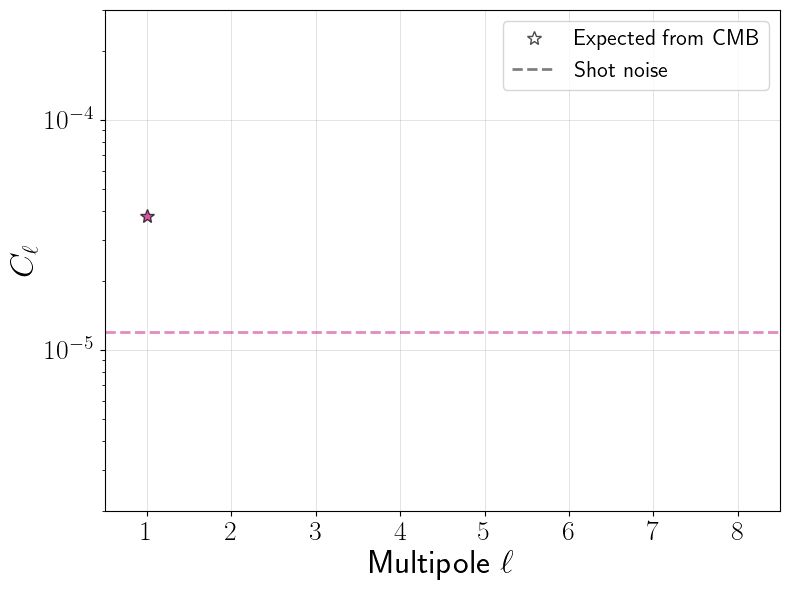

In [116]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
#ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)
#ax.plot(ells_mod, Cells_mod + noise_quaia_cross, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

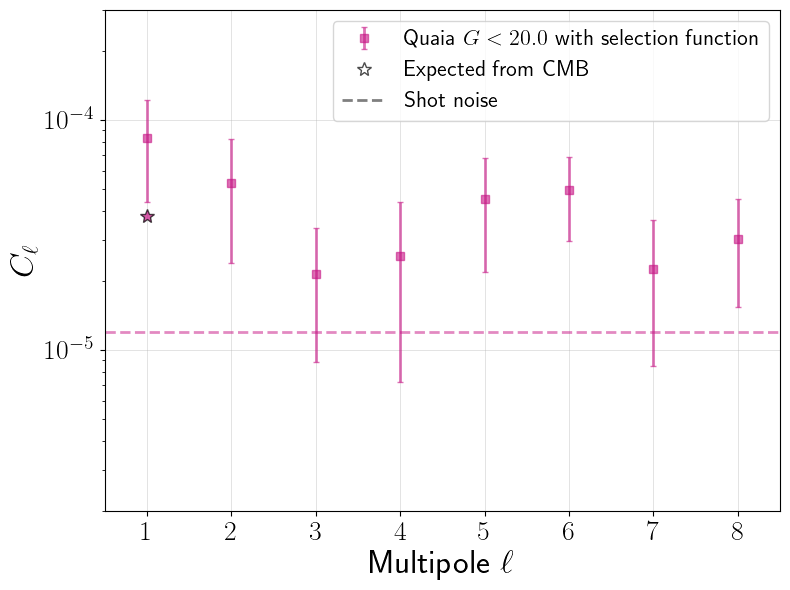

In [117]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
            c=color_quaia, label=r'Quaia $G<20.0$ with selection function', marker='s', **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
#ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

In [106]:
print(noise_catwise_Cell, noise_quaia_Cell)
# a cursed estimate, for now
noise_catwise_cross = noise_quaia_cross * noise_catwise_Cell/noise_quaia_Cell
print(noise_catwise_cross, noise_quaia_cross)

4.184726575445846e-06 6.385536595250998e-06
7.864134541597796e-06 1.2e-05


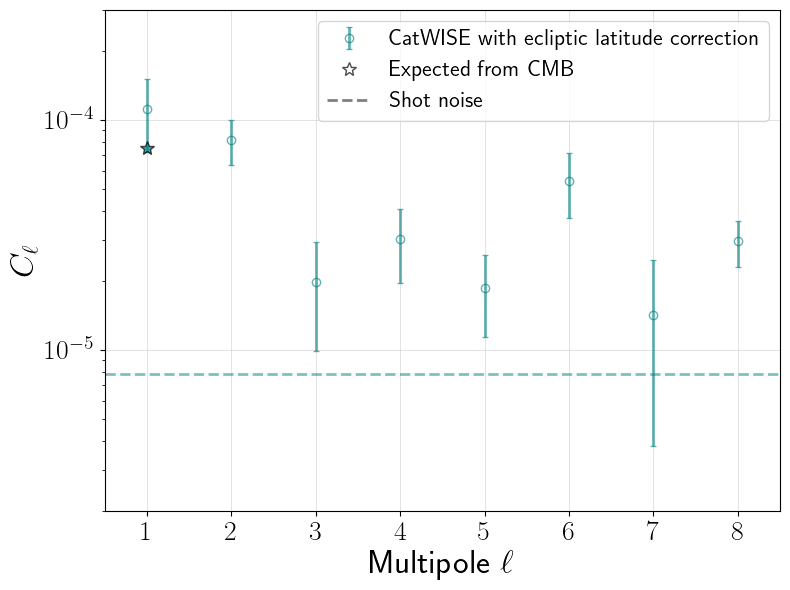

In [118]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
ax.errorbar(ells[1:], Cells_catwise[1:], yerr=Cells_catwise_std[1:],
        label='CatWISE with ecliptic latitude correction', c=color_catwise, marker='o', markerfacecolor='None', **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_catwise, c=color_catwise, **kwargs)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_catwise_cross, c=color_catwise, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

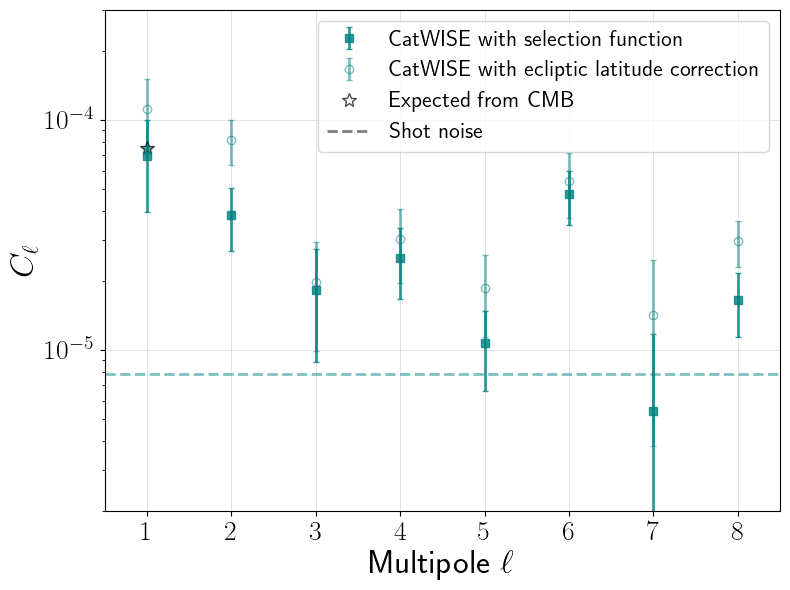

In [119]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, capsize=2, lw=lw)
ax.errorbar(ells[1:], Cells_sf_catwise[1:], alpha=0.8, yerr=Cells_sf_catwise_std[1:],
            label='CatWISE with selection function', c=color_catwise, marker='s', **kwargs)
ax.errorbar(ells[1:], Cells_catwise[1:], alpha=0.5, yerr=Cells_catwise_std[1:],
        label='CatWISE with ecliptic latitude correction', c=color_catwise, marker='o', markerfacecolor='None', **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_catwise, c=color_catwise, **kwargs)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_catwise_cross, c=color_catwise, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

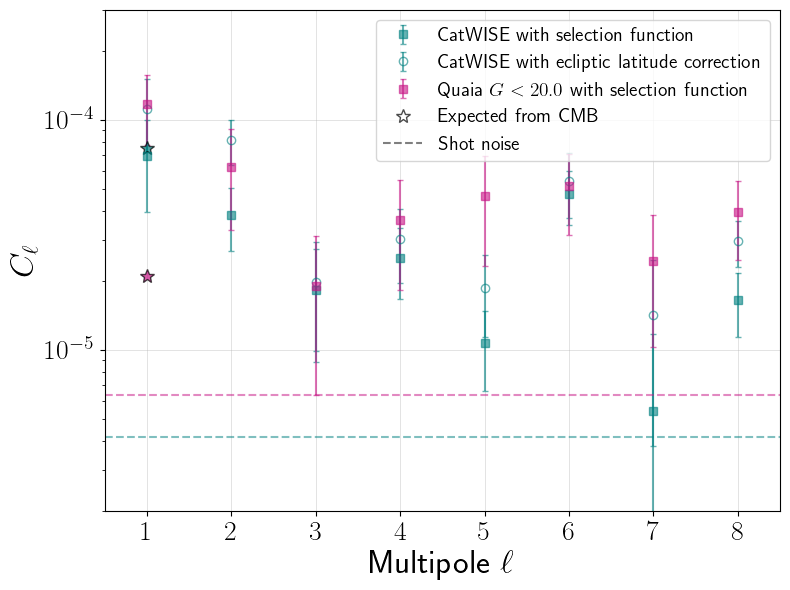

In [31]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
ax.errorbar(ells[1:], Cells_sf_catwise[1:], yerr=Cells_sf_catwise_std[1:],
            label='CatWISE with selection function', c=color_catwise, marker='s', **kwargs)
ax.errorbar(ells[1:], Cells_catwise[1:], yerr=Cells_catwise_std[1:],
        label='CatWISE with ecliptic latitude correction', c=color_catwise, marker='o', markerfacecolor='None', **kwargs)
ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
            c=color_quaia, label=r'Quaia $G<20.0$ with selection function', marker='s', **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_catwise, c=color_catwise, **kwargs)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5)
ax.axhline(noise_catwise_Cell, c=color_catwise, **kwargs)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

### reconstruct the best-fit maps

In [96]:
# choose a few max ells
max_ells = [1,2,8]

# where to store the reconstructed maps, AND the recovered dipole direction
reconstructed_maps_catwise = np.empty((len(max_ells), d.NPIX))
dipdirs_catwise = []
reconstructed_maps_sf_catwise = np.empty((len(max_ells), d.NPIX))
dipdirs_sf_catwise = []
reconstructed_maps_quaia = np.empty((len(max_ells), d.NPIX))
dipdirs_quaia = []
for i, max_ell_ in enumerate(max_ells):
    # CatWISE
    _, _, alms = multipoles.compute_Cells_in_overdensity_map(overdensity_map_elat_catwise,
                                                              Wmask=Wmask, max_ell=max_ell_, selfunc=None, return_alms=True)
    reconstructed_maps_catwise[i] = multipoles.reconstruct_map(alms, d.NSIDE)
    dipdirs_catwise.append(dipole.get_dipole(alms[1:4], from_alms=True)[1]) # [1] gives us the direction as an astropy SkyCoord
    _, _, alms = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_catwise,
                                                              Wmask=Wmask, max_ell=max_ell_, selfunc=selfunc_catwise, return_alms=True)
    reconstructed_maps_sf_catwise[i] = multipoles.reconstruct_map(alms, d.NSIDE)
    dipdirs_sf_catwise.append(dipole.get_dipole(alms[1:4], from_alms=True)[1])
    # Quaia
    _, _, alms = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_quaia,
                                                              Wmask=Wmask, max_ell=max_ell_, selfunc=selfunc_quaia, return_alms=True)
    reconstructed_maps_quaia[i] = multipoles.reconstruct_map(alms, d.NSIDE)
    dipdirs_quaia.append(dipole.get_dipole(alms[1:4], from_alms=True)[1])

In [97]:
# expected dipole direction
cmb_dipamp, cmb_dipdir = dipole.cmb_dipole()

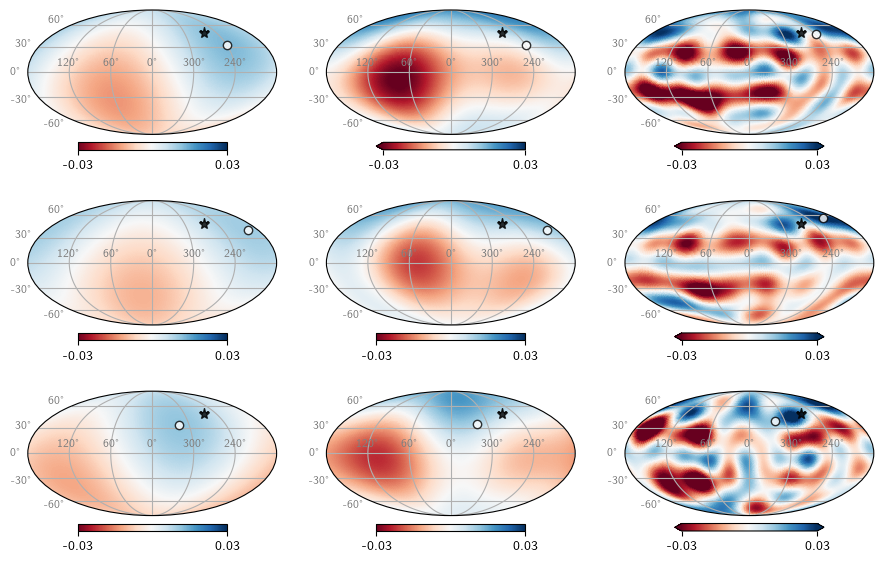

In [98]:
# plott
fig = plt.figure(figsize=(3 * len(max_ells), 6))

kwargs = dict(coord=['C','G'], min=-.03, max=.03, fig=fig, cmap='RdBu',
              graticule=True, graticule_labels=True, xtick_label_color='grey', ytick_label_color='grey',
             fontsize={'xtick_label':8, 'ytick_label':8})

for i, max_ell_ in enumerate(max_ells):
    hp.projview(reconstructed_maps_catwise[i], sub=(3, len(max_ells), i+1),
                title='', **kwargs)
    tools.plot_marker(dipdirs_catwise[i].galactic.l, dipdirs_catwise[i].galactic.b,
                          marker='o', c='w', mec='k', ms=6, alpha=0.8)
    tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
                          marker='*', c='k', ms=8, alpha=0.8)
    hp.projview(reconstructed_maps_sf_catwise[i], sub=(3, len(max_ells), i+4),
                title='', **kwargs)
    tools.plot_marker(dipdirs_sf_catwise[i].galactic.l, dipdirs_sf_catwise[i].galactic.b,
                          marker='o', c='w', mec='k', ms=6, alpha=0.8)
    tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
                          marker='*', c='k', ms=8, alpha=0.8)
    hp.projview(reconstructed_maps_quaia[i], sub=(3, len(max_ells), i+7),
                title='', **kwargs)
    tools.plot_marker(dipdirs_quaia[i].galactic.l, dipdirs_quaia[i].galactic.b,
                          marker='o', c='w', mec='k', ms=6, alpha=0.8)
    tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b,
                          marker='*', c='k', ms=8, alpha=0.8)

### compare Cells with our regularization to Cells with standard / Secrest's fitting

In [37]:
# Cells with our regularization have already been computed above

In [38]:
# with standard / Secrest's fitting: we just exclude masked pixels from the fit
ells, Cells_standard_catwise = multipoles.compute_Cells_in_overdensity_map(overdensity_map_elat_catwise,
                                                                           Wmask=Wmask, max_ell=max_ell, selfunc=None,
                                                                           idx_to_fit=~np.isnan(overdensity_map_elat_catwise))
                                                                            # * this last idx_to_fit makes Wmask irrelevant in the fit
ells, Cells_standard_sf_catwise = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_catwise,
                                                                           Wmask=Wmask, max_ell=max_ell, selfunc=selfunc_catwise,
                                                                           idx_to_fit=~np.isnan(overdensity_map_sf_catwise))
ells, Cells_standard_quaia = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_quaia,
                                                                         Wmask=Wmask, max_ell=max_ell, selfunc=selfunc_quaia,
                                                                         idx_to_fit=~np.isnan(overdensity_map_sf_quaia))

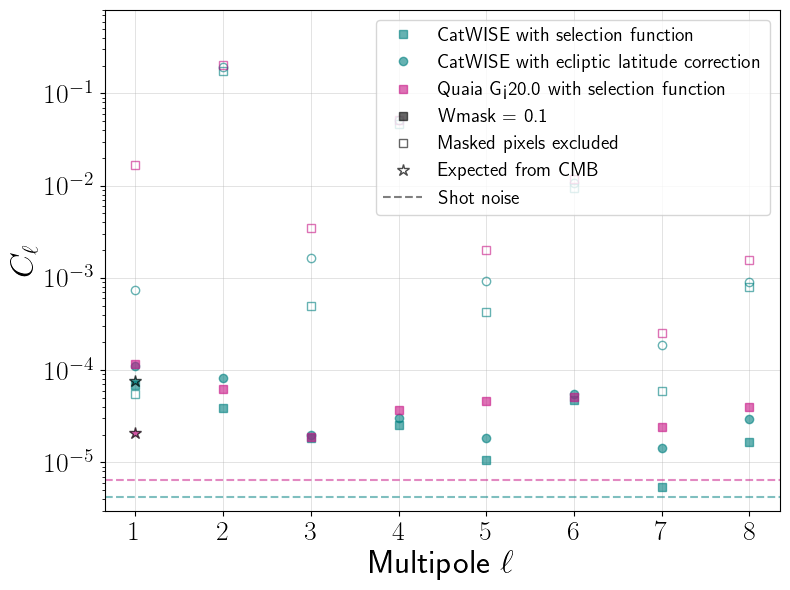

In [39]:
# plottt
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
kwargs = dict(ls='None', ms=6, alpha=0.6)
ax.plot(ells[1:], Cells_sf_catwise[1:], label='CatWISE with selection function', c=color_catwise, marker='s', **kwargs)
ax.plot(ells[1:], Cells_catwise[1:], label='CatWISE with ecliptic latitude correction', c=color_catwise, marker='o', **kwargs)
ax.plot(ells[1:], Cells_quaia[1:], c=color_quaia, label='Quaia G<20.0 with selection function', marker='s', **kwargs)

# standard fit !
ax.plot(ells[1:], Cells_standard_sf_catwise[1:], mec=color_catwise, c='None', marker='s', **kwargs)
ax.plot(ells[1:], Cells_standard_catwise[1:], mec=color_catwise, c='None', marker='o', **kwargs)
ax.plot(ells[1:], Cells_standard_quaia[1:], mec=color_quaia, c='None', marker='s', **kwargs)
# manual labels
marker = mpl.lines.Line2D([0], [0], label='Wmask = 0.1', c='k', marker='s', markersize=6, **kwargs)
standard_marker = mpl.lines.Line2D([0], [0], label='Masked pixels excluded', marker='s', mec='k', c='None', markersize=6, **kwargs)

# expected dipole amplitude
kwargs = dict(marker='*', ms=9, mec='k', alpha=0.7)
ax.plot(1, expected_C1_catwise, c=color_catwise, **kwargs)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs)
# manual label
cmb_marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5)
ax.axhline(noise_catwise_Cell, c=color_catwise, **kwargs)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, standard_marker, cmb_marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_ylim(3e-6, 8e-1)
ax.set_xlabel(r'Multipole $\ell$')
ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
ax.legend(loc=1, handles=handles)

### dipole amplitude as a function of regularization strength

#### CatWISE

In [40]:
# first, just the dipole:
# choose a few Wmasks / regularization strengths
Wmasks = np.logspace(-3, 3, 19)

C1s_elat_catwise = np.empty_like(Wmasks)
C1s_sf_catwise = np.empty_like(Wmasks)
for i, Wmask_ in enumerate(Wmasks):
    # compute the Cells and store the dipole amplitude:

    # ecliptic latitude corrected
    ells_, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map_elat_catwise,
                                                              Wmask=Wmask_, max_ell=1, selfunc=None)
    C1s_elat_catwise[i] = Cells[1]

    # selection function corrected
    ells_, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_catwise,
                                                              Wmask=Wmask_, max_ell=1, selfunc=selfunc_catwise)
    C1s_sf_catwise[i] = Cells[1]

# and "standard" fits:
# ecliptic latitude corrected:
ells_, Cells_standard_ = multipoles.compute_Cells_in_overdensity_map(overdensity_map_elat_catwise,
                                                                     Wmask=Wmask_, max_ell=1, selfunc=None,
                                                                     idx_to_fit=~np.isnan(overdensity_map_elat_catwise))
C1_standard_catwise = Cells_standard_[1]
ells_, Cells_sf_standard_ = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_catwise,
                                                                     Wmask=Wmask_, max_ell=1, selfunc=selfunc_catwise,
                                                                     idx_to_fit=~np.isnan(overdensity_map_sf_catwise))
C1_standard_sf_catwise = Cells_sf_standard_[1]

In [143]:
print(expected_dipamp_catwise)
print(D(C1_standard_catwise)/expected_dipamp_catwise)
print(D(C1_standard_sf_catwise)/expected_dipamp_catwise)
#print(D(C1s_quaia[np.argmin(np.abs(Wmasks-0.1))])/expected_dipamp_quaia)

0.007360511581619875
1.8098116495436434
1.4430736701531395


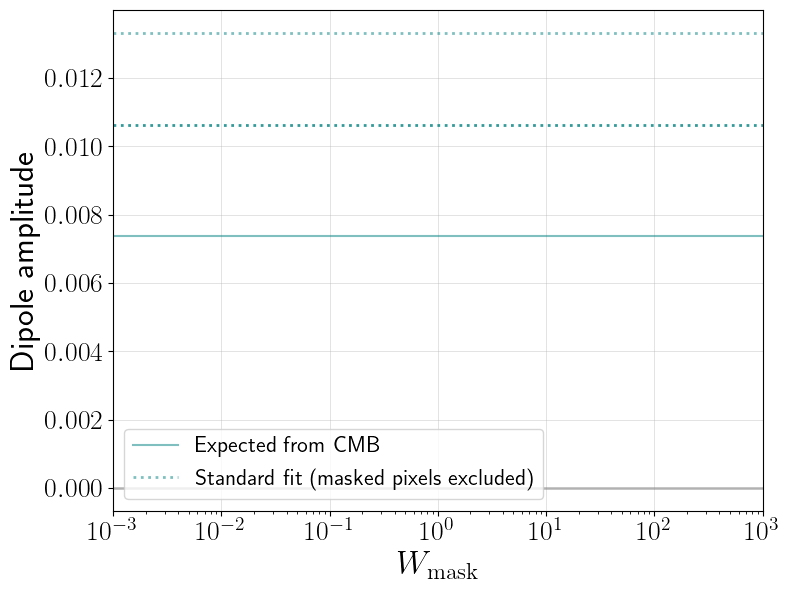

In [146]:
# plot but **transform back to dipole amplitudes**
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

# some lines:
ax.axhline(expected_dipamp_catwise, c=color_catwise, alpha=0.5, label='Expected from CMB')
ax.axhline(D(C1_standard_catwise), c=color_catwise, alpha=0.5, ls=':', lw=lw, label='Standard fit (masked pixels excluded)')
ax.axhline(D(C1_standard_sf_catwise), c=color_catwise, alpha=0.8, ls=':', lw=lw)
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$W_\mathrm{mask}$')
ax.set_xlim(np.min(Wmasks), np.max(Wmasks))

#ax.set_ylabel(r'$C_1$')
ax.set_ylabel('Dipole amplitude')
ax.semilogx()
ax.legend(loc='lower left')

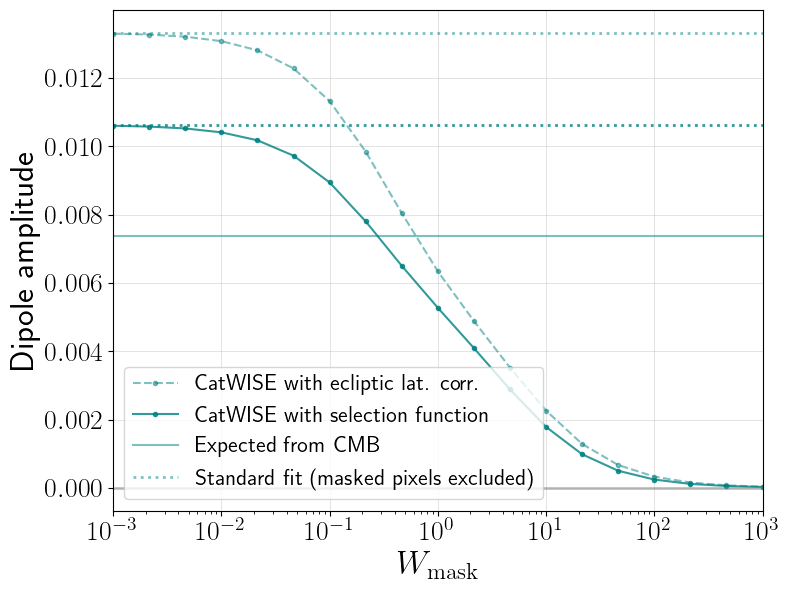

In [131]:
# plot but **transform back to dipole amplitudes**
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

ax.plot(Wmasks, D(C1s_elat_catwise), c=color_catwise, alpha=0.5, ls='--', marker='.', label='CatWISE with ecliptic lat. corr.')
ax.plot(Wmasks, D(C1s_sf_catwise), c=color_catwise, alpha=0.8, marker='.', label='CatWISE with selection function')

# some lines:
ax.axhline(expected_dipamp_catwise, c=color_catwise, alpha=0.5, label='Expected from CMB')
ax.axhline(D(C1_standard_catwise), c=color_catwise, alpha=0.5, ls=':', lw=lw, label='Standard fit (masked pixels excluded)')
ax.axhline(D(C1_standard_sf_catwise), c=color_catwise, alpha=0.8, ls=':', lw=lw)
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$W_\mathrm{mask}$')
#ax.set_ylabel(r'$C_1$')
ax.set_ylabel('Dipole amplitude')
ax.set_xlim(np.min(Wmasks), np.max(Wmasks))

ax.semilogx()
ax.legend(loc='lower left')

In [43]:
# choose a few max ells
max_ells_maxells = np.arange(1, 7).astype(int)

# and Wmasks / regularization strengths
Wmasks_maxells = np.logspace(-3 ,1, 19)

In [44]:
C1s_elat_catwise_maxells = np.empty((len(max_ells_maxells), len(Wmasks_maxells)))
C1s_sf_catwise_maxells = np.empty((len(max_ells_maxells), len(Wmasks_maxells)))
for i, max_ell_ in enumerate(max_ells_maxells):
    for j, Wmask_ in enumerate(Wmasks_maxells):
        print(f"max_ell = {max_ell_}, Wmask = {Wmask_}", end='\r')
    
        # ecliptic latitude corrected
        ells_, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map_elat_catwise,
                                                                  Wmask=Wmask_, max_ell=max_ell_, selfunc=None)
        C1s_elat_catwise_maxells[i,j] = Cells[1]
    
        # selection function corrected
        ells_, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_catwise,
                                                                  Wmask=Wmask_, max_ell=max_ell_, selfunc=selfunc_catwise)
        C1s_sf_catwise_maxells[i,j] = Cells[1]

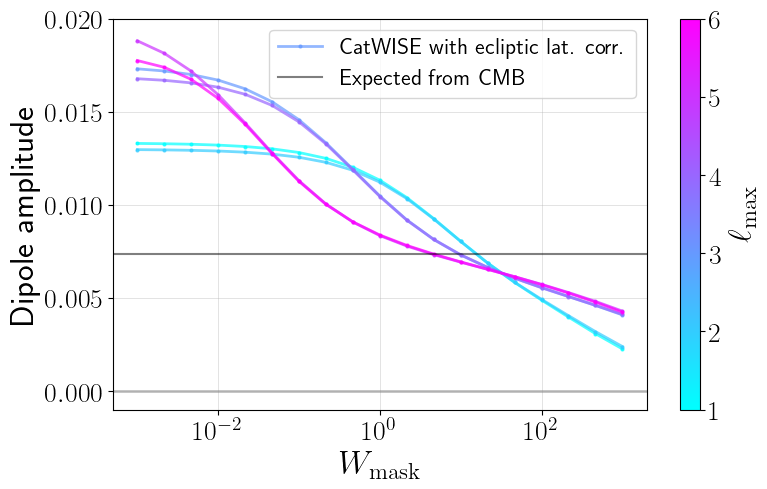

In [153]:
norm = mpl.colors.Normalize(vmin=min(max_ells_maxells), vmax=max(max_ells_maxells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, max_ell_ in enumerate(max_ells_maxells):
    label = 'CatWISE with ecliptic lat. corr.' if i==len(max_ells)-1 else ''
    ax.plot(Wmasks, D(C1s_elat_catwise_maxells[i]), c=smap.to_rgba(max_ell_), alpha=0.7, marker='.', ms=4,
           label=label, lw=lw)

ax.axhline(expected_dipamp_catwise, c='k', alpha=0.5, label='Expected from CMB')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$W_\mathrm{mask}$')
ax.set_ylabel(r'Dipole amplitude')
ax.semilogx()
ax.legend(loc='upper right')
#ax.legend(loc='lower left')
ax.set_ylim(-0.001, 0.02)

fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$', ticks=max_ells_maxells)

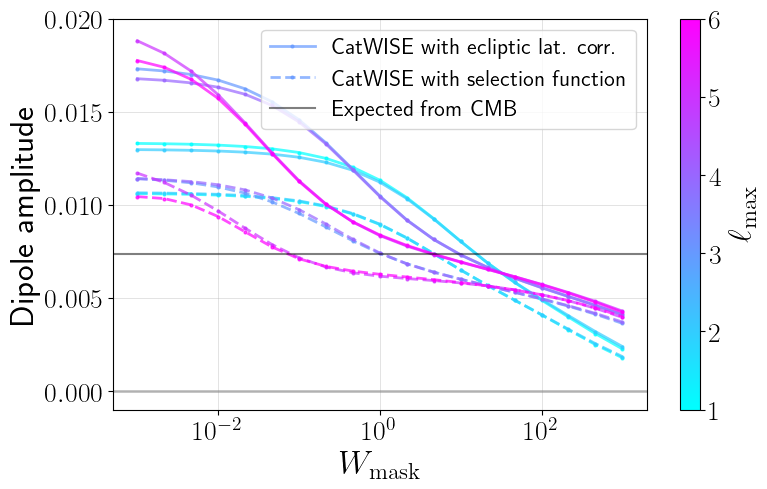

In [142]:
norm = mpl.colors.Normalize(vmin=min(max_ells_maxells), vmax=max(max_ells_maxells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, max_ell_ in enumerate(max_ells_maxells):
    label = 'CatWISE with ecliptic lat. corr.' if i==len(max_ells)-1 else ''
    ax.plot(Wmasks, D(C1s_elat_catwise_maxells[i]), c=smap.to_rgba(max_ell_), alpha=0.7, marker='.', ms=4,
           label=label, lw=lw)
    label = 'CatWISE with selection function' if i==len(max_ells)-1 else ''
    ax.plot(Wmasks, D(C1s_sf_catwise_maxells[i]), c=smap.to_rgba(max_ell_), alpha=0.7, marker='.', ms=4, ls='--',
           label=label, lw=lw)

ax.axhline(expected_dipamp_catwise, c='k', alpha=0.5, label='Expected from CMB')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$W_\mathrm{mask}$')
ax.set_ylabel(r'Dipole amplitude')
ax.semilogx()
#ax.legend(loc='lower left')
ax.legend(loc='upper right')
ax.set_ylim(-0.001, 0.02)
fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$', ticks=max_ells_maxells)

### Quaia

In [65]:
# first, just the dipole:
# choose a few Wmasks / regularization strengths
Wmasks = np.logspace(-3, 3, 19)

C1s_quaia = np.empty_like(Wmasks)
for i, Wmask_ in enumerate(Wmasks):
    # compute the Cells and store the dipole amplitude:

    # ecliptic latitude corrected
    ells_, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_quaia,
                                                              Wmask=Wmask_, max_ell=1, selfunc=selfunc_quaia)
    C1s_quaia[i] = Cells[1]

# and "standard" fits:
ells_, Cells_standard_ = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_quaia,
                                                                     Wmask=Wmask_, max_ell=1, selfunc=selfunc_quaia,
                                                                     idx_to_fit=~np.isnan(overdensity_map_sf_quaia))
C1_standard_quaia = Cells_standard_[1]

1000.0
0.00047920344991918853
0.00047920344991918853


In [63]:
D(C1_standard_quaia)

0.015678070514367388

In [140]:
print(expected_dipamp_quaia)
print(D(C1_standard_quaia)/expected_dipamp_quaia)
print(D(C1s_quaia[np.argmin(np.abs(Wmasks-0.1))])/expected_dipamp_quaia)

0.005231860180606647
2.996653192775017
2.2435948161738173


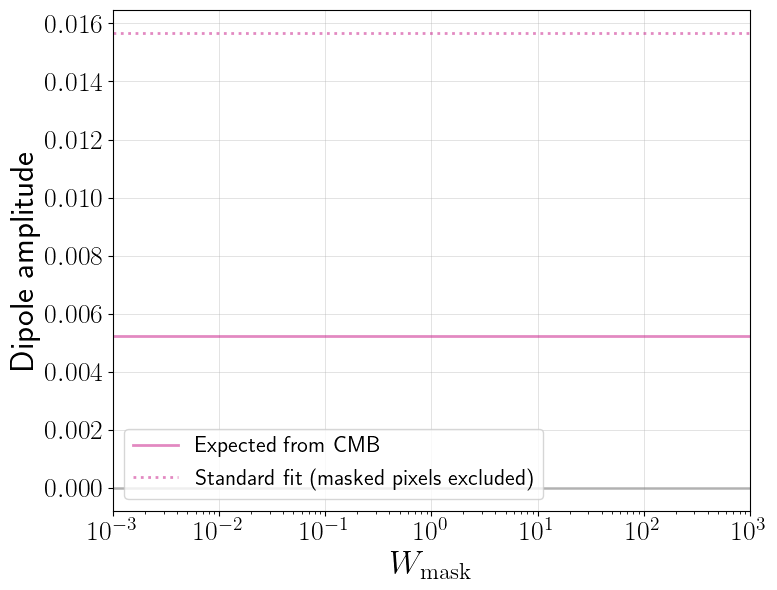

In [136]:
# plot but **transform back to dipole amplitudes**
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

# some lines:
ax.axhline(expected_dipamp_quaia, c=color_quaia, alpha=0.5, lw=lw, label='Expected from CMB')
ax.axhline(D(C1_standard_quaia), c=color_quaia, alpha=0.5,  lw=lw, ls=':', label='Standard fit (masked pixels excluded)')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$W_\mathrm{mask}$')
#ax.set_ylabel(r'$C_1$')
ax.set_ylabel('Dipole amplitude')
ax.semilogx()
ax.set_xlim(np.min(Wmasks), np.max(Wmasks))

ax.legend(loc='lower left')

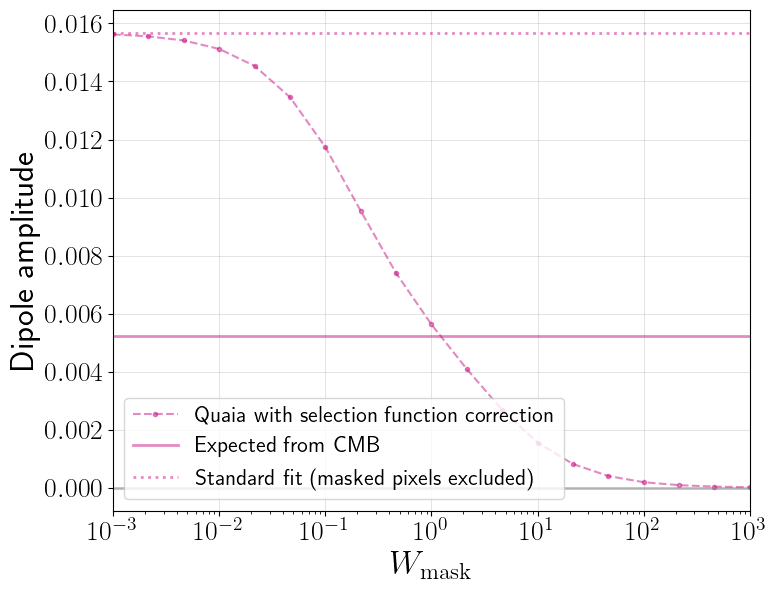

In [137]:
# plot but **transform back to dipole amplitudes**
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)

ax.plot(Wmasks, D(C1s_quaia), c=color_quaia, alpha=0.5, ls='--', marker='.', 
        label='Quaia with selection function correction')

# some lines:
ax.axhline(expected_dipamp_quaia, c=color_quaia, alpha=0.5, lw=lw, label='Expected from CMB')
ax.axhline(D(C1_standard_quaia), c=color_quaia, alpha=0.5, lw=lw, ls=':',label='Standard fit (masked pixels excluded)')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$W_\mathrm{mask}$')
#ax.set_ylabel(r'$C_1$')
ax.set_ylabel('Dipole amplitude')
ax.semilogx()
ax.set_xlim(np.min(Wmasks), np.max(Wmasks))
ax.legend(loc='lower left')

In [138]:
C1s_quaia_maxells = np.empty((len(max_ells_maxells), len(Wmasks_maxells)))
for i, max_ell_ in enumerate(max_ells_maxells):
    for j, Wmask_ in enumerate(Wmasks_maxells):
        print(f"max_ell = {max_ell_}, Wmask = {Wmask_}", end='\r')
    
        ells_, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_quaia,
                                                                  Wmask=Wmask_, max_ell=max_ell_, selfunc=selfunc_quaia)
        C1s_quaia_maxells[i,j] = Cells[1]

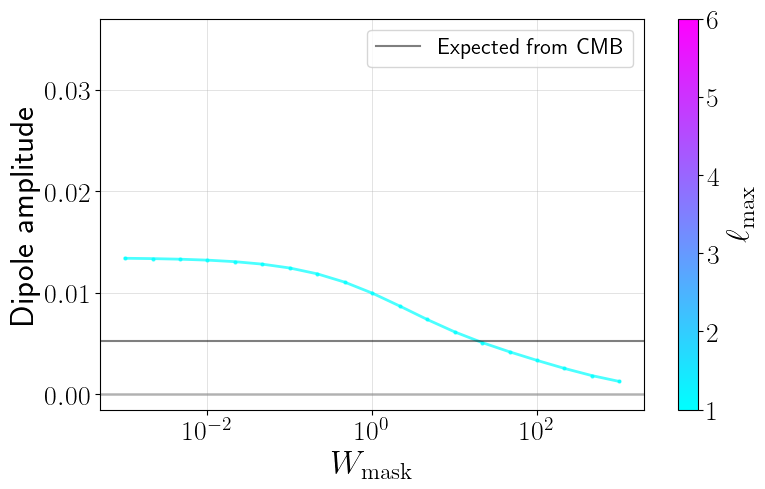

In [152]:
norm = mpl.colors.Normalize(vmin=min(max_ells_maxells), vmax=max(max_ells_maxells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, max_ell_ in enumerate(max_ells_maxells[:1]):
    label = 'Quaia with selection function' if i==len(max_ells)-1 else ''
    ax.plot(Wmasks, D(C1s_quaia_maxells[i]), c=smap.to_rgba(max_ell_), alpha=0.7, lw=lw, marker='.', ms=4, ls='-',
           label=label)

ax.axhline(expected_dipamp_quaia, c='k', alpha=0.5, label='Expected from CMB')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$W_\mathrm{mask}$')
ax.set_ylabel(r'Dipole amplitude')
ax.semilogx()
ax.legend(loc='upper right')
ax.set_ylim(-0.0015, 0.037)

fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$', ticks=max_ells_maxells)

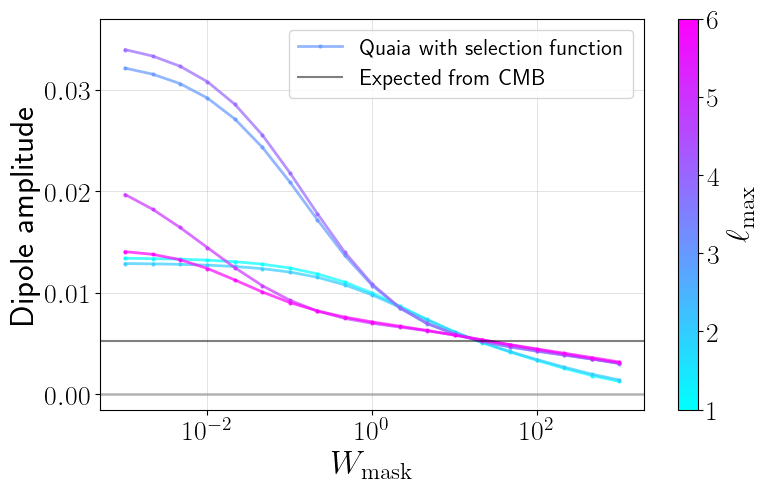

In [151]:
norm = mpl.colors.Normalize(vmin=min(max_ells_maxells), vmax=max(max_ells_maxells))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

for i, max_ell_ in enumerate(max_ells_maxells):
    label = 'Quaia with selection function' if i==len(max_ells)-1 else ''
    ax.plot(Wmasks, D(C1s_quaia_maxells[i]), c=smap.to_rgba(max_ell_), alpha=0.7, lw=lw, marker='.', ms=4, ls='-',
           label=label)

ax.axhline(expected_dipamp_quaia, c='k', alpha=0.5, label='Expected from CMB')
ax.axhline(0, c='grey', alpha=0.5, lw=lw)
ax.grid(alpha=0.5, lw=lw_grid)
ax.set_xlabel(r'$W_\mathrm{mask}$')
ax.set_ylabel(r'Dipole amplitude')
ax.semilogx()
ax.legend(loc='upper right')
ax.set_ylim(-0.0015, 0.037)

fig.colorbar(smap, ax=ax, label=r'$\ell_\mathrm{max}$', ticks=max_ells_maxells)